# Modelo de classificação kNN
Neste arquivo vamos criar um modelo kNN e otimizar seus hiperparâmetros para fazer previsões do estado de saúde dos pacientes a partir de seus biomarcadores. O dataframe escolhido para este estudo tem uma coluna denominada Class, que guarda o estado do indivíduo, entre Control e Impaired. Os indivíduos classificados como Control são indivíduos de controle saudáveis, enquanto Impaired são indivíduos afetados por Alzheimer.

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from optuna import create_study
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [2]:
# Importando dados
features = pd.read_csv("Features selecionadas para treino.csv")
features = features.drop("Unnamed: 0", axis=1)

target = pd.read_csv("Target para treino.csv")
target = target["Class"]
features = features.values

In [3]:
#Normalizando o target:
le = LabelEncoder()
target = le.fit_transform(target)

In [4]:
# Preparando a otimização de hiperparâmetros com optuna
#Criando as funções auxiliares
def instancia_geral(trial, parametros, algoritmo):
    modelo = algoritmo(**parametros)
    return modelo

def objetivo_geral(trial, parametros, algoritmo):
    modelo = instancia_geral(trial, parametros, algoritmo)
    metricas = cross_val_score(
        modelo,
        features,
        target,
        scoring="accuracy",
        cv= 5
    )
    return metricas.mean()


def funcao_objetivo_parcial_knn(trial):
    parametros = {"n_neighbors": trial.suggest_int("n_neighbors", 2, 100),
                  "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
                  "p": trial.suggest_int("p", 1, 2)}
    return objetivo_geral(trial, parametros, KNeighborsClassifier)

In [5]:
NOME_DO_ESTUDO = "knn"
estudo_knn = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

estudo_knn.optimize(funcao_objetivo_parcial_knn, n_trials=1000)

[I 2025-10-17 16:01:34,646] A new study created in RDB with name: knn
[I 2025-10-17 16:01:39,604] Trial 0 finished with value: 0.7350204081632652 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.7350204081632652.
[I 2025-10-17 16:01:39,837] Trial 1 finished with value: 0.7506938775510205 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.7506938775510205.
[I 2025-10-17 16:01:40,052] Trial 2 finished with value: 0.730938775510204 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.7506938775510205.
[I 2025-10-17 16:01:40,336] Trial 3 finished with value: 0.7228571428571428 and parameters: {'n_neighbors': 55, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.7506938775510205.
[I 2025-10-17 16:01:40,635] Trial 4 finished with value: 0.7269387755102039 and parameters: {'n_neighbors': 83, 'weights': 'distance', 'p': 2}. Best is trial 1 with val

In [6]:
# Treinando um modelo k-NN com estes parâmetros
params = estudo_knn.best_trial.params

predictor = KNeighborsClassifier(**params)
predictor.fit(features, target)

,n_neighbors,12
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,1
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [7]:
#Importando dados de teste
X = pd.read_csv("Features selecionadas para teste.csv")
X = X.drop("Unnamed: 0", axis=1).values
y_pd = pd.read_csv("Target para teste.csv")
Y = y_pd["Class"]

nle = LabelEncoder()
y = nle.fit_transform(Y)

In [8]:
predictor = KNeighborsClassifier(**params)
predictor.fit(features, target)
y_pred = predictor.predict(X)
accuracy = accuracy_score(y, y_pred)
print(accuracy)

y_pred_trans = nle.inverse_transform(y_pred)
y_pred_trans

0.7857142857142857


array(['Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Impaired', 'Impaired', 'Control',
       'Control', 'Control', 'Impaired', 'Control', 'Control', 'Control',
       'Control', 'Impaired', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Impaired', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Impaired',
       'Control', 'Impaired', 'Impaired', 'Control', 'Control', 'Control',
       'Control', 'Impaired', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'C

['Control' 'Impaired']


<Axes: >

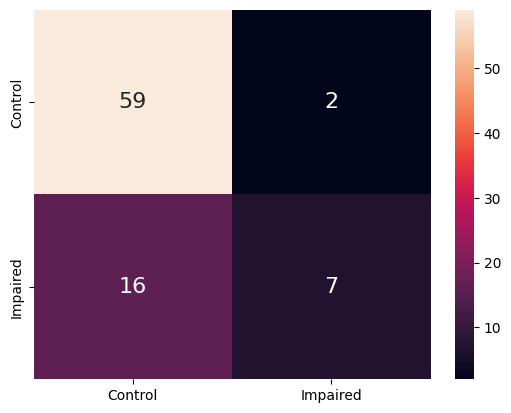

In [9]:
#Montando a matriz de confusão 
classes = np.unique(y_pred_trans)
print(classes)
cm = confusion_matrix(Y, y_pred_trans, labels=classes)
df_conf = pd.DataFrame(cm, classes, classes)
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16})

## Conclusões:
Nosso modelo apresenta grande viés para classificar indivíduos como saudáveis. Apesar de ter acertado a maioria dos indivíduos saudáveis, classificou a maior parte dos doentes como saudáveis, apresentando um falso negativo muito forte. Isso pode acontecer porque o modelo k-NN é suscetível à qualidade dos vizinhos, e como em nossos dados de treino, a quantidade de indivíduos saudáveis é maior que a de doentes, muito provavelmente, nosso modelo foi enviezado para esta categoria. A razão entre a quantidade de acertos na previsão de pessoas doentes e a quantidade real de pessoas doentes é menor que um terço, o que torna nosso modelo insatisfatório.